In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.stats.api as sms

## Design Our Experiment 

Let's imagine we work at a e-commerce businness, and you are planning on designing a new landing page. The web developer has worked hard on a new version of the landing page with the hope that it will lead to a higher conversion rate. Currently, the conversion rate is about **16%** on average throughout the year. The team is targeting an increase **3%** meaning the new design will be a success if it raises the conversion rate to **19%**.

### Formulating Our Hypothesis

$H_0$: $p$ = $p_0$

$H_a$: $p \neq p_0$

## Load The Data

In [7]:
path = "archive (4)/ab_data.csv"

df = pd.read_csv(path)

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
# Choosing the variable 
df["group"].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

<AxesSubplot:xlabel='group'>

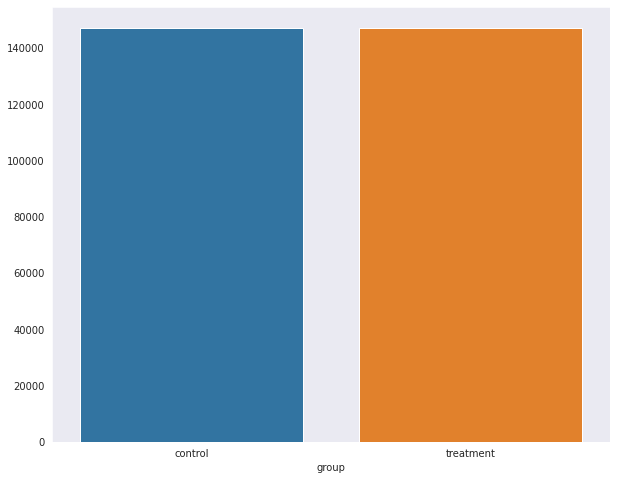

In [23]:
# EDA - Univairate analysis

data = df.groupby("group")["group"].count()

fig, ax = plt.subplots(figsize=(10,8))

sns.set_style("dark")

sns.barplot(x=data.index, y=data.values, ax=ax)

In [24]:
# dependet variable (what we are measuring)
df["converted"].value_counts()

0    259241
1     35237
Name: converted, dtype: int64

* 0 - False *The user did not buy the product*
* 1 - True *The user bought the product during the session*

## Choose a sample Size

* Assume this the whole population data.
* We won't test the whole user base, instead use a sample.

In [26]:
import matplotlib as mpl
from math import ceil

effect_size = sms.proportion_effectsize(0.16, 0.19) # calculating our effect size 

# calculating the sample size need
required_n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

# round up the number
required_n = ceil(required_n)

required_n

2514

In [30]:
# Checking for duplicated users

df.duplicated(subset=["user_id"]).sum()

3894

In [31]:
# drop the duplicated users 
df.drop_duplicates(subset=["user_id"], keep="first",inplace=True)

df.shape

(290584, 5)

## Sampling 

In [33]:
# control group sample

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=42)

# treatement group sample

treat_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=42)

# combine our samples together 

data = pd.concat([control_sample, treat_sample], axis=0)

data.reset_index(drop=True, inplace=True)

data.head()

,user_id,timestamp,group,landing_page,converted
0,723859,2017-01-13 13:23:44.371785,control,old_page,1
1,729591,2017-01-03 10:26:48.735727,control,old_page,0
2,791807,2017-01-13 16:59:18.346932,control,old_page,0
3,695740,2017-01-11 16:04:38.540309,control,old_page,0
4,712633,2017-01-13 12:26:18.400155,control,old_page,0


In [34]:
# preview sample data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5028 non-null   int64 
 1   timestamp     5028 non-null   object
 2   group         5028 non-null   object
 3   landing_page  5028 non-null   object
 4   converted     5028 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 196.5+ KB


In [37]:
data["group"].value_counts()

control      2514
treatment    2514
Name: group, dtype: int64

In [43]:
conversion_rates = data.groupby('group')['converted']
# standard deviation
std = lambda x: np.std(x, ddof=0)
# standard error
se = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std, se])
conversion_rates.columns = ['conversion_rate', 'std deviation', 'std error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std deviation,std error
group,,,
control,0.119,0.323,0.006
treatment,0.107,0.310,0.006


* The two designs performed almost similar, with the old design performing slightly better, 10.7% in the new design and 11.9% old design.

## Test The hypothesis

In [46]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [47]:
control = data[data['group'] == 'control']['converted']
treatment = data[data['group'] == 'treatment']['converted']


In [50]:
n_con = control.count()

n_treat = treatment.count()

success = [control.sum(), treatment.sum()]
nobs = [n_con, n_treat]

In [51]:
z_stat, pval = proportions_ztest(success, nobs)

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(success, nobs=nobs, alpha=0.05)


print(f'z statistic: {z_stat:.2f}')

print(f'p-value: {pval:.3f}')

print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')

print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.25
p-value: 0.212
ci 95% for control group: [0.106, 0.131]
ci 95% for treatment group: [0.095, 0.120]


* $p_value = 0.212$ is way above our $\alpha$=0.05.
* We are going to fail to reject the Null hypothesis $H_0$, which means **the new design did not perform significantly different than the old one**.
* The ```Confidence Intervals``` for treatment group ```[9.5%, 12%]``` indicates:
>>The baseline conversion value was 9.5%.

>>Doesn't inclue the target value of **19%** we were aiming for. 

* The conversion rate for the control and treatment group are almost the same, meaning the new design had no impact.

## Disclaimmer

We didn't test the conversion rate, we just assumed it to be 16%. 